In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

# Predictive Regression Modeling Workflow

## Students Will Be Able To
 - Understand the basic outline of a predictive modeling workflow
 - Describe the similarities and differences between this predictive regression workflow and the previous (Phase 2) inferential regression workflow

## Business Understanding and Data Understanding

This dataset was downloaded from [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho) and contains information about **used car sale listings**.  We are trying to **predict the price** associated with the listing.

### Features (as described on Kaggle)
 - `Car_Name`: The name of the car
 - `Year`: The year in which the car was bought
 - `Selling_Price`: The price the owner wants to sell the car at
 - `Present_Price`: The current ex-showroom price of the car
 - `Kms_Driven`: The distance completed by the car in km
 - `Fuel_Type`: The fuel type of the car (`Petrol`, `Diesel`, or Other)
 - `Seller_Type`: Whether the seller is a dealer or an individual
 - `Transmission`: Whether the car is manual or automatic
 - `Owner`: The number of owners the car has previously had

Looking at the original website, it looks like the prices are listed in lakhs, meaning hundreds of thousands of rupees.

In [2]:
df = pd.read_csv("cars.csv")

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

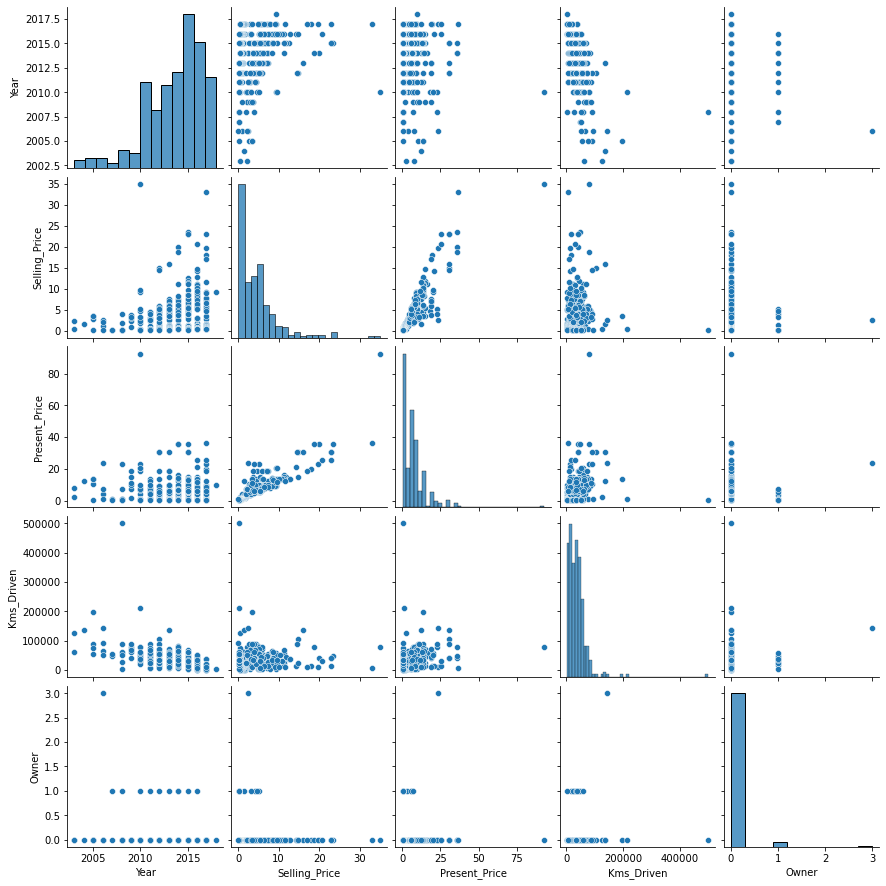

In [6]:
sns.pairplot(df);

### *Compare and Contrast: Business Understanding and Data Understanding*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Mostly the same...looked at what features we have, missing values, descriptive statistics
plots

Difference: we're trying to predict price, we don't necessarily care about the relationship
between the features and the target
"""

## Train-Test Split

Before performing any preprocessing or modeling, set aside a holdout test set

In [7]:
X = df.drop("Selling_Price", axis=1)
y = df["Selling_Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### *Compare and Contrast: Train-Test Split*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Difference: train and test sets separate

Similarity: identify, separate out the target variable
"""

## Baseline Model: Dummy Model with Numeric Features Only

We have four numeric features (`Year`, `Present_Price`, `Kms_Driven`, and `Owner`) and four non-numeric features (`Car_Name`, `Fuel_Type`, `Seller_Type`, `Transmission`).  Before doing any of the engineering work to be able to use those non-numeric features, let's just try using the numeric ones


[Documentation for Sklearn's DummyRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)

In [8]:
baseline = DummyRegressor(strategy='median')
X_train_numeric = X_train[["Year", "Present_Price", "Kms_Driven", "Owner"]].copy()

In [9]:
baseline_cross_val_score = cross_val_score(baseline, X_train_numeric, y_train, cv=5)
baseline_cross_val_score

array([-0.04190543, -0.00017595, -0.06861601, -0.01195328, -0.1607309 ])

### *Compare and Contrast: Baseline Model*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Differences:
- Not using all the data, just using training data
- Using cross validation, which we didn't do before
- Model evaluation is just r-squared
- Didn't check assumptions
- Not using StatsModels, using SciKit-Learn
- Used a dummy model first

Similarities:
- Using r-squared to evaluate
"""

## Linear Regression Model - Numerical Features

In [10]:
lin_reg_model = LinearRegression()

In [11]:
baseline_cross_val_score = cross_val_score(lin_reg_model, X_train_numeric, y_train, cv=5)
baseline_cross_val_score

array([0.67168559, 0.75626366, 0.88591659, 0.79241643, 0.84299344])

Ok, not too bad, we are getting somewhere between 0.67 and 0.89 r-squared for a linear regression with just the numeric features

## Add One-Hot Encoded Features

Let's see if adding in some of those non-numeric features helps

In [12]:
X_train_all_features = X_train.copy()

In [13]:
def encode_and_concat_feature_train(X_train_all_features, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)
    single_feature_df = X_train_all_features[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train_all_features = encode_and_concat_feature(X_train_all_features, feature_name, ohe)
    
    return ohe, X_train_all_features

In [14]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df)
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=single_feature_df.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X.drop(feature_name, axis=1, inplace=True)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [15]:
# we will need each of these encoders later for transforming the test data

fuel_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Fuel_Type")
seller_type_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Seller_Type")
transmission_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Transmission")
# putting car name at the end just because it has the most categories
car_name_ohe, X_train_all_features = encode_and_concat_feature_train(X_train_all_features, "Car_Name")

In [16]:
X_train_all_features.columns

Index(['Year', 'Present_Price', 'Kms_Driven', 'Owner', 'CNG', 'Diesel',
       'Petrol', 'Dealer', 'Individual', 'Automatic', 'Manual', '800',
       'Activa 3g', 'Bajaj  ct 100', 'Bajaj Avenger 150',
       'Bajaj Avenger 150 street', 'Bajaj Avenger 220',
       'Bajaj Avenger 220 dtsi', 'Bajaj Avenger Street 220',
       'Bajaj Discover 100', 'Bajaj Discover 125', 'Bajaj Dominar 400',
       'Bajaj Pulsar 135 LS', 'Bajaj Pulsar 150', 'Bajaj Pulsar 220 F',
       'Bajaj Pulsar NS 200', 'Bajaj Pulsar RS200', 'Hero  Ignitor Disc',
       'Hero Extreme', 'Hero Glamour', 'Hero Honda Passion Pro', 'Hero Hunk',
       'Hero Passion Pro', 'Hero Passion X pro', 'Hero Splender Plus',
       'Hero Splender iSmart', 'Hero Super Splendor', 'Honda Activa 4G',
       'Honda CB Hornet 160R', 'Honda CB Shine', 'Honda CB Unicorn',
       'Honda CB twister', 'Honda CBR 150', 'Honda Karizma', 'Hyosung GT250R',
       'KTM 390 Duke ', 'KTM RC200', 'KTM RC390', 'Royal Enfield Bullet 350',
       'Royal En

In [17]:
X_train_all_features

,Year,Present_Price,Kms_Driven,Owner,CNG,Diesel,Petrol,Dealer,Individual,Automatic,...,innova,jazz,land cruiser,omni,ritz,swift,sx4,verna,wagon r,xcent
129,2017,0.84,5000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,2015,14.79,12900,0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,2015,0.32,35000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,2015,13.60,21780,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280,2015,5.90,14465,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2013,0.57,18000,0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,2011,12.48,45000,0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,2014,3.45,16500,1,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,2011,10.00,69341,0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### *Compare and Contrast: One-Hot Encoding*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Similarity:
- Dummying out categorical variables (our model still needs 100% numbers)

Differences:
- Didn't drop any columns when dummying categorical variables (not worried about multicollinearity)
- We added everything, didn't do much EDA beforehand or add features one at a time
"""

## Linear Regression with More Features

In [18]:
lin_reg_model = LinearRegression()

print("Old:", baseline_cross_val_score)
print("New:", cross_val_score(lin_reg_model, X_train_all_features, y_train, cv=5))

Old: [0.67168559 0.75626366 0.88591659 0.79241643 0.84299344]
New: [0.53767269 0.75859933 0.91658648 0.75885906 0.75269983]


That looks worse.  What if we don't use the car name, and just use the categories with 1-3 values?

In [ ]:
X_train_all_except_car_name = X_train_all_features[[
                    "Year",
                    "Present_Price",
                    "Kms_Driven",
                    "Owner",
                    "CNG",
                    "Diesel",
                    "Petrol",
                    "Dealer",
                    "Individual",
                    "Automatic",
                    "Manual"
                ]].copy()
X_train_all_except_car_name

In [ ]:
lin_reg_model = LinearRegression()

print("Old:", baseline_cross_val_score)
print("New:", cross_val_score(lin_reg_model, X_train_all_except_car_name, y_train, cv=5))

Ok, adding these categories improved r-squared for 4 out of 5 subsamples compared to just having numeric features, so let's keep them for our linear regression model

In [ ]:
best_linreg_cross_val_score = cross_val_score(lin_reg_model, X_train_all_except_car_name, y_train, cv=5)

### *Compare and Contrast: Linear Regression with More Features*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Differences:
- Just compared r-squared
- Used cross validation
"""

## Try a More Advanced Model

It depends on our business case whether these numbers are sufficient.  We are explaining approximately somewhere between 65% and 92% of the variance in the sale price.  But let's try a more complicated model.

First, just using the X_train values used in the linear regression:

In [ ]:
random_forest_regressor_model_1 = RandomForestRegressor(n_estimators=10, random_state=42)

print("Old:", best_linreg_cross_val_score)
print("New:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train, cv=5))

Ok, this more-sophisticated model is performing slightly better on 4 of 5 subsamples than the best linear regression score.  Let's see what happens if we add the car names back in:

In [ ]:
random_forest_regressor_model_2 = RandomForestRegressor(n_estimators=10, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train, cv=5))
print("New:", cross_val_score(random_forest_regressor_model_2, X_train_all_features, y_train, cv=5))

Only one of the subsamples improved with adding this feature, and everything else got worse

## Hyperparameter Tuning the More Advanced Model

Let's add some more "power" to the random forest regressor, since it's running reasonably quickly right now

In [ ]:
random_forest_regressor_model_3 = RandomForestRegressor(n_estimators=1000, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_1, X_train_all_except_car_name, y_train, cv=5))
print("New:", cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train, cv=5))

That marginally improved 4 of the 5 subsamples (but was significantly slower to run).  Let's try including the car name again:

In [ ]:
random_forest_regressor_model_4 = RandomForestRegressor(n_estimators=1000, random_state=42)

print("Old:", cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train, cv=5))
print("New:", cross_val_score(random_forest_regressor_model_4, X_train_all_features, y_train, cv=5))

Again, that didn't really seem to help.  So if we're stopping right now, we can say that the third random forest regressor is the best model.

### *Compare and Contrast: Hyperparameter Tuning*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Similar:
- Adding more features isn't always better
- Sometimes the last model you build isn't the best
- We're iteratively building models until we run out of time, then picked the "best"

Different:
- Before, didn't have hyperparameters to tune, now we do
- Computational complexity is a concern
"""

## Model Evaluation

Now that we have chosen a best model, let's use the holdout set to see how well the final model does

### Preprocessing to Use Test Data
First, perform all of the same transformations on the test X that were performed on the train X

In [ ]:
X_test_all_except_car_name = X_test.reset_index().drop(["index", "Car_Name"], axis=1)

# fuel_type_ohe, seller_type_ohe, and transmission_ohe were fitted on the training data
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Fuel_Type", fuel_type_ohe)
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Seller_Type", seller_type_ohe)
X_test_all_except_car_name = encode_and_concat_feature(X_test_all_except_car_name, "Transmission", transmission_ohe)

X_test_all_except_car_name

### Fitting and Scoring Final Model

Fit our best model on all of the training data

In [ ]:
random_forest_regressor_model_3.fit(X_train_all_except_car_name, y_train)

Score our best model on the test data

In [ ]:
random_forest_regressor_model_3.score(X_test_all_except_car_name, y_test)

That's pretty good!  We have a model that is able to explain 97% of the variance in the car sale list prices

### Fitting and Scoring Baseline Model

Let's compare that to the baseline model:

In [ ]:
lin_reg_model.fit(X_train_numeric, y_train)

In [ ]:
X_test_numeric = X_test[["Year", "Present_Price", "Kms_Driven", "Owner"]].copy()

lin_reg_model.score(X_test_numeric, y_test)

So, our r-squared has improved from a baseline of 85% to 97%.

### Other Metrics

To report something more applicable to a business audience, let's calculate the [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) using the [metrics submodule of scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, random_forest_regressor_model_3.predict(X_test_all_except_car_name))
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

To interpret this: on average, our prediction of `Selling_Price` is off (either too high or too low) by about 0.9 lakh, i.e. about 90,000 rupees (about 1200 USD)

Let's compare that to the baseline model:

In [ ]:
baseline_mse = mean_squared_error(y_test, lin_reg_model.predict(X_test_numeric))
np.sqrt(baseline_mse)

So, the baseline model was off by about 2 lakh, i.e. about 200,000 rupees (about 2600 USD)

### Visualization of Model Performance

Also, here is a plot that shows the actual vs. predicted prices:

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Customize which model is actually being plotted
ax1.set_title("Baseline Regression Model Performance")
ax1.scatter(y_test, lin_reg_model.predict(X_test_numeric),
                alpha=0.5, label="model output", color="green")

ax2.set_title("Final Regression Model Performance")
ax2.scatter(y_test, random_forest_regressor_model_3.predict(X_test_all_except_car_name),
                alpha=0.5, label="model output")

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 25)
for ax in (ax1, ax2):
    ax.set_xlabel("True Price (Lakhs)")
    ax.set_ylabel("Predicted Price (Lakhs)")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

### *Compare and Contrast: Model Evaluation*

What (if anything) was similar between this process and the previous process?  What (if anything) was different?

In [ ]:
"""
Differences:
- Before we had a scatter plot with residuals, looking for heteroskedasticity
  Now we are just comparing the predicted vs. actual values
- No linear regression assumption check visualizations (or statistics), so no
  Q-Q plot
- Final evaluation that is different from what we were doing along the way
  - "Along the way" we didn't use the test data, we used cross-validation instead
  - At the end, we did use test data, didn't use cross-validation
  - The goal is to avoid "manually overfitting" by choosing based on test set performance

Similarities:
- Comparison to a baseline (showing improvement)

Overall process differences:
- We didn't stop to evaluate after adding each individual feature
"""

### Appendix 1

Quick note about `RandomForestRegressor` and why it "performed better on the test than on the train".  This isn't quite a correct characterization, but it's worth thinking about

Let's look at the scores again from when we were choosing a "best model":

In [ ]:
print(cross_val_score(random_forest_regressor_model_3, X_train_all_except_car_name, y_train))

And again, the code for the final evaluation of the "best model":

In [ ]:
random_forest_regressor_model_3.fit(X_train_all_except_car_name, y_train)
random_forest_regressor_model_3.score(X_test_all_except_car_name, y_test)

It's definitely true that the cross-validated scores range from 73% to 93%, whereas the final evaluation score is 97% — a good amount higher

But the important thing to be clear on is that these are _both_ scores on "test data", just different test sets.  For the cross-validated scores, those are scores from training on a subset and then testing on a subset of the training data.  Then the final score is created by training on the whole training set and testing on the test set.

If we scored the final model on the train set, it's actually even better:

In [ ]:
random_forest_regressor_model_3.score(X_train_all_except_car_name, y_train)

But, to go back to the original question, why is the final test score so much better than the cross-validated test scores?

First, a reminder that we are working with a pretty tiny dataset:

In [ ]:
X_train.shape

In [ ]:
# 5 splits for cross-validation
225 / 5

In [ ]:
# 4 out of 5 splits used for training, remaining used for testing
45 * 4

In [ ]:
X_test.shape

Since we are doing a 5-fold cross-validation, that means that the cross-validated scores are each being computed with:

 - 180 rows in the training set
 - 45 rows in the test set

By comparison, our overall model evaluation is using all of `X`, which means:

 - 225 rows in the training set
 - 76 rows in the test set

When we are working with such a small dataset, being able to train on 45 additional data points (and having the errors in the test data be spread out over 31 more data points) can naturally mean better performance.  It's typical for final results to be better than cross-validated results unless you have a very large dataset!

Separately, we might have just randomly chosen a "lucky" test set, that includes fewer outliers on average, or is more easily predicted by the features we have (rather than some unknown features we don't have). Because we used cross-validation to choose our final model (rather than evaluating on the test set to choose our final model), this random concern could just as easily be an "unlucky" test set as a "lucky" one.  But if we had used the test set for choosing a model, we could run into issues where we systematically overestimate our model's predictive abilities, because we didn't actually evaluate on unseen data.